# Pipeline

### Data input

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Importing the dataset
df = pd.read_csv('creditcard.csv')
df = df.drop(['Time'], axis=1)
df.reset_index(drop=True, inplace=True)

### Data preprocessing

### Model hyperparameter tuning

In [7]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer 

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    LogisticRegression()
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'logisticregression__C': [ 0.1, 1, 5],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
}

As the data set in very unbalanced, we will use the F1 score as the metric to evaluate the model performance.

In [8]:
from sklearn.model_selection import train_test_split
f1_score_list_lg = []
k=5

# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2, random_state=42)

# Train model
grid = GridSearchCV(pipeline, param_grid=params_grid, cv=4, scoring="f1", verbose=3)
grid.fit(X_train, y_train)
model = grid.best_estimator_

for ind in range(k):
    # Evaluate model
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2, random_state=42 + ind)
    model.fit(X_train, y_train)
    y_pred = pd.DataFrame(model.predict_proba(X_test)[:,-1] > 0.2)
    y_test = pd.DataFrame(y_test)
    f1_score_list_lg.append(f1_score(y_test, y_pred))

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.646 total time=   0.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.663 total time=   0.4s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.732 total time=   0.4s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.756 total time=   0.4s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.646 total time=   0.6s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.713 total time=   0.7s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.739 total time=   0.8s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=l

c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.743 total time=   1.9s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.637 total time=   0.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.663 total time=   0.5s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.724 total time=   0.4s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.756 total time=   0.5s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.654 total time=   0.7s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.702 total time=   0.8s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0

c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.646 total time=   1.9s


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.718 total time=   1.7s


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.726 total time=   1.7s


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.735 total time=   1.9s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.646 total time=   0.4s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.663 total time=   0.5s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.732 total time=   0.5s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.756 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.658 total time=   0.9s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.713 total time=   0.9s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.739 total time=

c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.646 total time=   2.0s


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.718 total time=   2.0s


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.726 total time=   1.8s


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.735 total time=   1.8s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.646 total time=   0.4s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.663 total time=   0.4s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.732 total time=   0.4s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.756 total time=   0.5s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.654 total time=   0.9s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.713 total time=   0.9s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.739 total time=

In [9]:
print(f"The average f1 score for {k} LogisticRegression is: {sum(f1_score_list_lg)/k}, with the following parameters:\n {grid.best_params_}")

The average f1 score for 5 LogisticRegression is: 0.7453694595317019, with the following parameters:
 {'logisticregression__C': 1, 'logisticregression__solver': 'lbfgs', 'selectkbest__k': 15}


For LogisticRegression, we manage to have an average f1 score of 0.75 for 5 differents train/test splits. We take 0.2 as the threshold of the model, to better recognize the fraud.

In [10]:
import xgboost as xgb

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    xgb.XGBClassifier(early_stopping_rounds=2, tree_method='hist')
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.05],
}

In [11]:
# Split data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, validation = train_test_split(train, test_size=0.2)
Dtrain = xgb.DMatrix(train.drop(['Class'], axis=1), label=train['Class'])
Dval = xgb.DMatrix(validation.drop(['Class'], axis=1), label=validation['Class'])
Dtest = xgb.DMatrix(test.drop(['Class'], axis=1), label=test['Class'])

search_cv = []

for eta in [0.05, 0.1, 0.5]:
    for mdepth in [3, 7]:
        for tree_method in ['hist', 'approx', 'auto']:
            for threshold in [0.2, 0.3, 0.4, 0.5]:
                # Train model
                param = {
                    'max_depth': mdepth,
                    'eta': eta,
                    'objective': 'binary:logistic',
                    'tree_method': tree_method,
                }

                # Evaluate model
                num_round = 100
                eval_list = [(Dval, 'eval'), (Dtrain, 'train')]
                bst = xgb.train(param, Dtrain, num_round, eval_list, early_stopping_rounds=5, verbose_eval=10)

                # Model evaluation
                y_pred = pd.DataFrame(bst.predict(Dval) > threshold)
                y_val = pd.DataFrame(validation['Class'])
                f1_score(y_val, y_pred)
                search_cv.append([param, f1_score(y_val, y_pred), threshold])

c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future 

[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07356	train-logloss:0.07372
[20]	eval-logloss:0.04460	train-logloss:0.04481
[30]	eval-logloss:0.02752	train-logloss:0.02779
[40]	eval-logloss:0.01736	train-logloss:0.01767
[50]	eval-logloss:0.01127	train-logloss:0.01162
[60]	eval-logloss:0.00758	train-logloss:0.00797
[70]	eval-logloss:0.00536	train-logloss:0.00576
[80]	eval-logloss:0.00403	train-logloss:0.00443
[90]	eval-logloss:0.00324	train-logloss:0.00361
[99]	eval-logloss:0.00282	train-logloss:0.00315
[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07356	train-logloss:0.07372


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04460	train-logloss:0.04481
[30]	eval-logloss:0.02752	train-logloss:0.02779
[40]	eval-logloss:0.01736	train-logloss:0.01767
[50]	eval-logloss:0.01127	train-logloss:0.01162
[60]	eval-logloss:0.00758	train-logloss:0.00797
[70]	eval-logloss:0.00536	train-logloss:0.00576
[80]	eval-logloss:0.00403	train-logloss:0.00443
[90]	eval-logloss:0.00324	train-logloss:0.00361
[99]	eval-logloss:0.00282	train-logloss:0.00315
[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07356	train-logloss:0.07372


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04460	train-logloss:0.04481
[30]	eval-logloss:0.02752	train-logloss:0.02779
[40]	eval-logloss:0.01736	train-logloss:0.01767
[50]	eval-logloss:0.01127	train-logloss:0.01162
[60]	eval-logloss:0.00758	train-logloss:0.00797
[70]	eval-logloss:0.00536	train-logloss:0.00576
[80]	eval-logloss:0.00403	train-logloss:0.00443
[90]	eval-logloss:0.00324	train-logloss:0.00361
[99]	eval-logloss:0.00282	train-logloss:0.00315
[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07356	train-logloss:0.07372


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04460	train-logloss:0.04481
[30]	eval-logloss:0.02752	train-logloss:0.02779
[40]	eval-logloss:0.01736	train-logloss:0.01767
[50]	eval-logloss:0.01127	train-logloss:0.01162
[60]	eval-logloss:0.00758	train-logloss:0.00797
[70]	eval-logloss:0.00536	train-logloss:0.00576
[80]	eval-logloss:0.00403	train-logloss:0.00443
[90]	eval-logloss:0.00324	train-logloss:0.00361
[99]	eval-logloss:0.00282	train-logloss:0.00315


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07357	train-logloss:0.07370
[20]	eval-logloss:0.04457	train-logloss:0.04476
[30]	eval-logloss:0.02751	train-logloss:0.02772
[40]	eval-logloss:0.01734	train-logloss:0.01758
[50]	eval-logloss:0.01126	train-logloss:0.01152
[60]	eval-logloss:0.00757	train-logloss:0.00788
[70]	eval-logloss:0.00535	train-logloss:0.00568
[80]	eval-logloss:0.00402	train-logloss:0.00433
[90]	eval-logloss:0.00323	train-logloss:0.00352
[99]	eval-logloss:0.00281	train-logloss:0.00305
[0]	eval-logloss:0.12407	train-logloss:0.12407


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07357	train-logloss:0.07370
[20]	eval-logloss:0.04457	train-logloss:0.04476
[30]	eval-logloss:0.02751	train-logloss:0.02772
[40]	eval-logloss:0.01734	train-logloss:0.01758
[50]	eval-logloss:0.01126	train-logloss:0.01152
[60]	eval-logloss:0.00757	train-logloss:0.00788
[70]	eval-logloss:0.00535	train-logloss:0.00568
[80]	eval-logloss:0.00402	train-logloss:0.00433
[90]	eval-logloss:0.00323	train-logloss:0.00352
[99]	eval-logloss:0.00281	train-logloss:0.00305
[0]	eval-logloss:0.12407	train-logloss:0.12407


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07357	train-logloss:0.07370
[20]	eval-logloss:0.04457	train-logloss:0.04476
[30]	eval-logloss:0.02751	train-logloss:0.02772
[40]	eval-logloss:0.01734	train-logloss:0.01758
[50]	eval-logloss:0.01126	train-logloss:0.01152
[60]	eval-logloss:0.00757	train-logloss:0.00788
[70]	eval-logloss:0.00535	train-logloss:0.00568
[80]	eval-logloss:0.00402	train-logloss:0.00433
[90]	eval-logloss:0.00323	train-logloss:0.00352
[99]	eval-logloss:0.00281	train-logloss:0.00305
[0]	eval-logloss:0.12407	train-logloss:0.12407


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07357	train-logloss:0.07370
[20]	eval-logloss:0.04457	train-logloss:0.04476
[30]	eval-logloss:0.02751	train-logloss:0.02772
[40]	eval-logloss:0.01734	train-logloss:0.01758
[50]	eval-logloss:0.01126	train-logloss:0.01152
[60]	eval-logloss:0.00757	train-logloss:0.00788
[70]	eval-logloss:0.00535	train-logloss:0.00568
[80]	eval-logloss:0.00402	train-logloss:0.00433
[90]	eval-logloss:0.00323	train-logloss:0.00352
[99]	eval-logloss:0.00281	train-logloss:0.00305


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07356	train-logloss:0.07372
[20]	eval-logloss:0.04460	train-logloss:0.04481
[30]	eval-logloss:0.02752	train-logloss:0.02779
[40]	eval-logloss:0.01736	train-logloss:0.01767
[50]	eval-logloss:0.01127	train-logloss:0.01162
[60]	eval-logloss:0.00758	train-logloss:0.00797
[70]	eval-logloss:0.00536	train-logloss:0.00576
[80]	eval-logloss:0.00403	train-logloss:0.00443
[90]	eval-logloss:0.00324	train-logloss:0.00361
[99]	eval-logloss:0.00282	train-logloss:0.00315
[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07356	train-logloss:0.07372


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04460	train-logloss:0.04481
[30]	eval-logloss:0.02752	train-logloss:0.02779
[40]	eval-logloss:0.01736	train-logloss:0.01767
[50]	eval-logloss:0.01127	train-logloss:0.01162
[60]	eval-logloss:0.00758	train-logloss:0.00797
[70]	eval-logloss:0.00536	train-logloss:0.00576
[80]	eval-logloss:0.00403	train-logloss:0.00443
[90]	eval-logloss:0.00324	train-logloss:0.00361
[99]	eval-logloss:0.00282	train-logloss:0.00315
[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07356	train-logloss:0.07372


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04460	train-logloss:0.04481
[30]	eval-logloss:0.02752	train-logloss:0.02779
[40]	eval-logloss:0.01736	train-logloss:0.01767
[50]	eval-logloss:0.01127	train-logloss:0.01162
[60]	eval-logloss:0.00758	train-logloss:0.00797
[70]	eval-logloss:0.00536	train-logloss:0.00576
[80]	eval-logloss:0.00403	train-logloss:0.00443
[90]	eval-logloss:0.00324	train-logloss:0.00361
[99]	eval-logloss:0.00282	train-logloss:0.00315
[0]	eval-logloss:0.12407	train-logloss:0.12407
[10]	eval-logloss:0.07356	train-logloss:0.07372


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04460	train-logloss:0.04481
[30]	eval-logloss:0.02752	train-logloss:0.02779
[40]	eval-logloss:0.01736	train-logloss:0.01767
[50]	eval-logloss:0.01127	train-logloss:0.01162
[60]	eval-logloss:0.00758	train-logloss:0.00797
[70]	eval-logloss:0.00536	train-logloss:0.00576
[80]	eval-logloss:0.00403	train-logloss:0.00443
[90]	eval-logloss:0.00324	train-logloss:0.00361
[99]	eval-logloss:0.00282	train-logloss:0.00315
[0]	eval-logloss:0.12404	train-logloss:0.12404
[10]	eval-logloss:0.07344	train-logloss:0.07353


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
[0]	eval-logloss:0.12404	train-logloss:0.12404
[10]	eval-logloss:0.07344	train-logloss:0.07353


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
[0]	eval-logloss:0.12404	train-logloss:0.12404


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07344	train-logloss:0.07353
[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
[0]	eval-logloss:0.12404	train-logloss:0.12404
[10]	eval-logloss:0.07344	train-logloss:0.07353


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
[0]	eval-logloss:0.12404	train-logloss:0.12404


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07342	train-logloss:0.07352
[20]	eval-logloss:0.04438	train-logloss:0.04450
[30]	eval-logloss:0.02726	train-logloss:0.02735
[40]	eval-logloss:0.01705	train-logloss:0.01711
[50]	eval-logloss:0.01095	train-logloss:0.01092
[60]	eval-logloss:0.00729	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00483
[80]	eval-logloss:0.00378	train-logloss:0.00337
[90]	eval-logloss:0.00298	train-logloss:0.00245
[99]	eval-logloss:0.00253	train-logloss:0.00188
[0]	eval-logloss:0.12404	train-logloss:0.12404


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07342	train-logloss:0.07352
[20]	eval-logloss:0.04438	train-logloss:0.04450
[30]	eval-logloss:0.02726	train-logloss:0.02735
[40]	eval-logloss:0.01705	train-logloss:0.01711
[50]	eval-logloss:0.01095	train-logloss:0.01092
[60]	eval-logloss:0.00729	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00483
[80]	eval-logloss:0.00378	train-logloss:0.00337
[90]	eval-logloss:0.00298	train-logloss:0.00245
[99]	eval-logloss:0.00253	train-logloss:0.00188
[0]	eval-logloss:0.12404	train-logloss:0.12404


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07342	train-logloss:0.07352
[20]	eval-logloss:0.04438	train-logloss:0.04450
[30]	eval-logloss:0.02726	train-logloss:0.02735
[40]	eval-logloss:0.01705	train-logloss:0.01711
[50]	eval-logloss:0.01095	train-logloss:0.01092
[60]	eval-logloss:0.00729	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00483
[80]	eval-logloss:0.00378	train-logloss:0.00337
[90]	eval-logloss:0.00298	train-logloss:0.00245
[99]	eval-logloss:0.00253	train-logloss:0.00188
[0]	eval-logloss:0.12404	train-logloss:0.12404


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07342	train-logloss:0.07352
[20]	eval-logloss:0.04438	train-logloss:0.04450
[30]	eval-logloss:0.02726	train-logloss:0.02735
[40]	eval-logloss:0.01705	train-logloss:0.01711
[50]	eval-logloss:0.01095	train-logloss:0.01092
[60]	eval-logloss:0.00729	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00483
[80]	eval-logloss:0.00378	train-logloss:0.00337
[90]	eval-logloss:0.00298	train-logloss:0.00245
[99]	eval-logloss:0.00253	train-logloss:0.00188


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.12404	train-logloss:0.12404
[10]	eval-logloss:0.07344	train-logloss:0.07353
[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
[0]	eval-logloss:0.12404	train-logloss:0.12404


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07344	train-logloss:0.07353
[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
[0]	eval-logloss:0.12404	train-logloss:0.12404
[10]	eval-logloss:0.07344	train-logloss:0.07353


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
[0]	eval-logloss:0.12404	train-logloss:0.12404


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07344	train-logloss:0.07353
[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
[0]	eval-logloss:0.11743	train-logloss:0.11747


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04233	train-logloss:0.04255
[20]	eval-logloss:0.01653	train-logloss:0.01685
[30]	eval-logloss:0.00727	train-logloss:0.00767
[40]	eval-logloss:0.00391	train-logloss:0.00432
[50]	eval-logloss:0.00273	train-logloss:0.00307
[60]	eval-logloss:0.00230	train-logloss:0.00254
[70]	eval-logloss:0.00217	train-logloss:0.00226
[80]	eval-logloss:0.00210	train-logloss:0.00207
[90]	eval-logloss:0.00207	train-logloss:0.00191
[99]	eval-logloss:0.00207	train-logloss:0.00177
[0]	eval-logloss:0.11743	train-logloss:0.11747


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04233	train-logloss:0.04255
[20]	eval-logloss:0.01653	train-logloss:0.01685
[30]	eval-logloss:0.00727	train-logloss:0.00767
[40]	eval-logloss:0.00391	train-logloss:0.00432
[50]	eval-logloss:0.00273	train-logloss:0.00307
[60]	eval-logloss:0.00230	train-logloss:0.00254
[70]	eval-logloss:0.00217	train-logloss:0.00226
[80]	eval-logloss:0.00210	train-logloss:0.00207
[90]	eval-logloss:0.00207	train-logloss:0.00191
[99]	eval-logloss:0.00207	train-logloss:0.00177
[0]	eval-logloss:0.11743	train-logloss:0.11747
[10]	eval-logloss:0.04233	train-logloss:0.04255


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01653	train-logloss:0.01685
[30]	eval-logloss:0.00727	train-logloss:0.00767
[40]	eval-logloss:0.00391	train-logloss:0.00432
[50]	eval-logloss:0.00273	train-logloss:0.00307
[60]	eval-logloss:0.00230	train-logloss:0.00254
[70]	eval-logloss:0.00217	train-logloss:0.00226
[80]	eval-logloss:0.00210	train-logloss:0.00207
[90]	eval-logloss:0.00207	train-logloss:0.00191
[99]	eval-logloss:0.00207	train-logloss:0.00177
[0]	eval-logloss:0.11743	train-logloss:0.11747
[10]	eval-logloss:0.04233	train-logloss:0.04255


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01653	train-logloss:0.01685
[30]	eval-logloss:0.00727	train-logloss:0.00767
[40]	eval-logloss:0.00391	train-logloss:0.00432
[50]	eval-logloss:0.00273	train-logloss:0.00307
[60]	eval-logloss:0.00230	train-logloss:0.00254
[70]	eval-logloss:0.00217	train-logloss:0.00226
[80]	eval-logloss:0.00210	train-logloss:0.00207
[90]	eval-logloss:0.00207	train-logloss:0.00191
[99]	eval-logloss:0.00207	train-logloss:0.00177
[0]	eval-logloss:0.11743	train-logloss:0.11747


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04234	train-logloss:0.04251
[20]	eval-logloss:0.01654	train-logloss:0.01677
[30]	eval-logloss:0.00730	train-logloss:0.00758
[40]	eval-logloss:0.00393	train-logloss:0.00423
[50]	eval-logloss:0.00275	train-logloss:0.00298
[60]	eval-logloss:0.00234	train-logloss:0.00245
[70]	eval-logloss:0.00220	train-logloss:0.00217
[80]	eval-logloss:0.00215	train-logloss:0.00199
[90]	eval-logloss:0.00214	train-logloss:0.00184
[99]	eval-logloss:0.00211	train-logloss:0.00174
[0]	eval-logloss:0.11743	train-logloss:0.11747


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04234	train-logloss:0.04251
[20]	eval-logloss:0.01654	train-logloss:0.01677
[30]	eval-logloss:0.00730	train-logloss:0.00758
[40]	eval-logloss:0.00393	train-logloss:0.00423
[50]	eval-logloss:0.00275	train-logloss:0.00298
[60]	eval-logloss:0.00234	train-logloss:0.00245
[70]	eval-logloss:0.00220	train-logloss:0.00217
[80]	eval-logloss:0.00215	train-logloss:0.00199
[90]	eval-logloss:0.00214	train-logloss:0.00184
[99]	eval-logloss:0.00211	train-logloss:0.00174
[0]	eval-logloss:0.11743	train-logloss:0.11747


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04234	train-logloss:0.04251
[20]	eval-logloss:0.01654	train-logloss:0.01677
[30]	eval-logloss:0.00730	train-logloss:0.00758
[40]	eval-logloss:0.00393	train-logloss:0.00423
[50]	eval-logloss:0.00275	train-logloss:0.00298
[60]	eval-logloss:0.00234	train-logloss:0.00245
[70]	eval-logloss:0.00220	train-logloss:0.00217
[80]	eval-logloss:0.00215	train-logloss:0.00199
[90]	eval-logloss:0.00214	train-logloss:0.00184
[99]	eval-logloss:0.00211	train-logloss:0.00174
[0]	eval-logloss:0.11743	train-logloss:0.11747


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04234	train-logloss:0.04251
[20]	eval-logloss:0.01654	train-logloss:0.01677
[30]	eval-logloss:0.00730	train-logloss:0.00758
[40]	eval-logloss:0.00393	train-logloss:0.00423
[50]	eval-logloss:0.00275	train-logloss:0.00298
[60]	eval-logloss:0.00234	train-logloss:0.00245
[70]	eval-logloss:0.00220	train-logloss:0.00217
[80]	eval-logloss:0.00215	train-logloss:0.00199
[90]	eval-logloss:0.00214	train-logloss:0.00184
[99]	eval-logloss:0.00211	train-logloss:0.00174


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.11743	train-logloss:0.11747
[10]	eval-logloss:0.04233	train-logloss:0.04255
[20]	eval-logloss:0.01653	train-logloss:0.01685
[30]	eval-logloss:0.00727	train-logloss:0.00767
[40]	eval-logloss:0.00391	train-logloss:0.00432
[50]	eval-logloss:0.00273	train-logloss:0.00307
[60]	eval-logloss:0.00230	train-logloss:0.00254
[70]	eval-logloss:0.00217	train-logloss:0.00226
[80]	eval-logloss:0.00210	train-logloss:0.00207
[90]	eval-logloss:0.00207	train-logloss:0.00191
[99]	eval-logloss:0.00207	train-logloss:0.00177
[0]	eval-logloss:0.11743	train-logloss:0.11747
[10]	eval-logloss:0.04233	train-logloss:0.04255


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01653	train-logloss:0.01685
[30]	eval-logloss:0.00727	train-logloss:0.00767
[40]	eval-logloss:0.00391	train-logloss:0.00432
[50]	eval-logloss:0.00273	train-logloss:0.00307
[60]	eval-logloss:0.00230	train-logloss:0.00254
[70]	eval-logloss:0.00217	train-logloss:0.00226
[80]	eval-logloss:0.00210	train-logloss:0.00207
[90]	eval-logloss:0.00207	train-logloss:0.00191
[99]	eval-logloss:0.00207	train-logloss:0.00177
[0]	eval-logloss:0.11743	train-logloss:0.11747
[10]	eval-logloss:0.04233	train-logloss:0.04255


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01653	train-logloss:0.01685
[30]	eval-logloss:0.00727	train-logloss:0.00767
[40]	eval-logloss:0.00391	train-logloss:0.00432
[50]	eval-logloss:0.00273	train-logloss:0.00307
[60]	eval-logloss:0.00230	train-logloss:0.00254
[70]	eval-logloss:0.00217	train-logloss:0.00226
[80]	eval-logloss:0.00210	train-logloss:0.00207
[90]	eval-logloss:0.00207	train-logloss:0.00191
[99]	eval-logloss:0.00207	train-logloss:0.00177
[0]	eval-logloss:0.11743	train-logloss:0.11747
[10]	eval-logloss:0.04233	train-logloss:0.04255


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01653	train-logloss:0.01685
[30]	eval-logloss:0.00727	train-logloss:0.00767
[40]	eval-logloss:0.00391	train-logloss:0.00432
[50]	eval-logloss:0.00273	train-logloss:0.00307
[60]	eval-logloss:0.00230	train-logloss:0.00254
[70]	eval-logloss:0.00217	train-logloss:0.00226
[80]	eval-logloss:0.00210	train-logloss:0.00207
[90]	eval-logloss:0.00207	train-logloss:0.00191
[99]	eval-logloss:0.00207	train-logloss:0.00177
[0]	eval-logloss:0.11738	train-logloss:0.11740
[10]	eval-logloss:0.04214	train-logloss:0.04227


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01626	train-logloss:0.01631
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00368	train-logloss:0.00325
[50]	eval-logloss:0.00247	train-logloss:0.00177
[60]	eval-logloss:0.00211	train-logloss:0.00110
[70]	eval-logloss:0.00198	train-logloss:0.00075
[80]	eval-logloss:0.00194	train-logloss:0.00052
[90]	eval-logloss:0.00193	train-logloss:0.00038
[99]	eval-logloss:0.00194	train-logloss:0.00030
[0]	eval-logloss:0.11738	train-logloss:0.11740
[10]	eval-logloss:0.04214	train-logloss:0.04227


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01626	train-logloss:0.01631
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00368	train-logloss:0.00325
[50]	eval-logloss:0.00247	train-logloss:0.00177
[60]	eval-logloss:0.00211	train-logloss:0.00110
[70]	eval-logloss:0.00198	train-logloss:0.00075
[80]	eval-logloss:0.00194	train-logloss:0.00052
[90]	eval-logloss:0.00193	train-logloss:0.00038
[99]	eval-logloss:0.00194	train-logloss:0.00030
[0]	eval-logloss:0.11738	train-logloss:0.11740
[10]	eval-logloss:0.04214	train-logloss:0.04227


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01626	train-logloss:0.01631
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00368	train-logloss:0.00325
[50]	eval-logloss:0.00247	train-logloss:0.00177
[60]	eval-logloss:0.00211	train-logloss:0.00110
[70]	eval-logloss:0.00198	train-logloss:0.00075
[80]	eval-logloss:0.00194	train-logloss:0.00052
[90]	eval-logloss:0.00193	train-logloss:0.00038
[99]	eval-logloss:0.00194	train-logloss:0.00030
[0]	eval-logloss:0.11738	train-logloss:0.11740
[10]	eval-logloss:0.04214	train-logloss:0.04227


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01626	train-logloss:0.01631
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00368	train-logloss:0.00325
[50]	eval-logloss:0.00247	train-logloss:0.00177
[60]	eval-logloss:0.00211	train-logloss:0.00110
[70]	eval-logloss:0.00198	train-logloss:0.00075
[80]	eval-logloss:0.00194	train-logloss:0.00052
[90]	eval-logloss:0.00193	train-logloss:0.00038
[99]	eval-logloss:0.00194	train-logloss:0.00030
[0]	eval-logloss:0.11738	train-logloss:0.11740


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04213	train-logloss:0.04224
[20]	eval-logloss:0.01623	train-logloss:0.01629
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00367	train-logloss:0.00326
[50]	eval-logloss:0.00247	train-logloss:0.00178
[60]	eval-logloss:0.00207	train-logloss:0.00111
[70]	eval-logloss:0.00196	train-logloss:0.00075
[80]	eval-logloss:0.00193	train-logloss:0.00052
[90]	eval-logloss:0.00191	train-logloss:0.00037
[99]	eval-logloss:0.00190	train-logloss:0.00029
[0]	eval-logloss:0.11738	train-logloss:0.11740


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04213	train-logloss:0.04224
[20]	eval-logloss:0.01623	train-logloss:0.01629
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00367	train-logloss:0.00326
[50]	eval-logloss:0.00247	train-logloss:0.00178
[60]	eval-logloss:0.00207	train-logloss:0.00111
[70]	eval-logloss:0.00196	train-logloss:0.00075
[80]	eval-logloss:0.00193	train-logloss:0.00052
[90]	eval-logloss:0.00191	train-logloss:0.00037
[99]	eval-logloss:0.00190	train-logloss:0.00029
[0]	eval-logloss:0.11738	train-logloss:0.11740


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04213	train-logloss:0.04224
[20]	eval-logloss:0.01623	train-logloss:0.01629
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00367	train-logloss:0.00326
[50]	eval-logloss:0.00247	train-logloss:0.00178
[60]	eval-logloss:0.00207	train-logloss:0.00111
[70]	eval-logloss:0.00196	train-logloss:0.00075
[80]	eval-logloss:0.00193	train-logloss:0.00052
[90]	eval-logloss:0.00191	train-logloss:0.00037
[99]	eval-logloss:0.00190	train-logloss:0.00029
[0]	eval-logloss:0.11738	train-logloss:0.11740


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.04213	train-logloss:0.04224
[20]	eval-logloss:0.01623	train-logloss:0.01629
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00367	train-logloss:0.00326
[50]	eval-logloss:0.00247	train-logloss:0.00178
[60]	eval-logloss:0.00207	train-logloss:0.00111
[70]	eval-logloss:0.00196	train-logloss:0.00075
[80]	eval-logloss:0.00193	train-logloss:0.00052
[90]	eval-logloss:0.00191	train-logloss:0.00037
[99]	eval-logloss:0.00190	train-logloss:0.00029


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.11738	train-logloss:0.11740
[10]	eval-logloss:0.04214	train-logloss:0.04227
[20]	eval-logloss:0.01626	train-logloss:0.01631
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00368	train-logloss:0.00325
[50]	eval-logloss:0.00247	train-logloss:0.00177
[60]	eval-logloss:0.00211	train-logloss:0.00110
[70]	eval-logloss:0.00198	train-logloss:0.00075
[80]	eval-logloss:0.00194	train-logloss:0.00052
[90]	eval-logloss:0.00193	train-logloss:0.00038
[99]	eval-logloss:0.00194	train-logloss:0.00030
[0]	eval-logloss:0.11738	train-logloss:0.11740
[10]	eval-logloss:0.04214	train-logloss:0.04227


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01626	train-logloss:0.01631
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00368	train-logloss:0.00325
[50]	eval-logloss:0.00247	train-logloss:0.00177
[60]	eval-logloss:0.00211	train-logloss:0.00110
[70]	eval-logloss:0.00198	train-logloss:0.00075
[80]	eval-logloss:0.00194	train-logloss:0.00052
[90]	eval-logloss:0.00193	train-logloss:0.00038
[99]	eval-logloss:0.00194	train-logloss:0.00030
[0]	eval-logloss:0.11738	train-logloss:0.11740
[10]	eval-logloss:0.04214	train-logloss:0.04227


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01626	train-logloss:0.01631
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00368	train-logloss:0.00325
[50]	eval-logloss:0.00247	train-logloss:0.00177
[60]	eval-logloss:0.00211	train-logloss:0.00110
[70]	eval-logloss:0.00198	train-logloss:0.00075
[80]	eval-logloss:0.00194	train-logloss:0.00052
[90]	eval-logloss:0.00193	train-logloss:0.00038
[99]	eval-logloss:0.00194	train-logloss:0.00030
[0]	eval-logloss:0.11738	train-logloss:0.11740
[10]	eval-logloss:0.04214	train-logloss:0.04227


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.01626	train-logloss:0.01631
[30]	eval-logloss:0.00700	train-logloss:0.00686
[40]	eval-logloss:0.00368	train-logloss:0.00325
[50]	eval-logloss:0.00247	train-logloss:0.00177
[60]	eval-logloss:0.00211	train-logloss:0.00110
[70]	eval-logloss:0.00198	train-logloss:0.00075
[80]	eval-logloss:0.00194	train-logloss:0.00052
[90]	eval-logloss:0.00193	train-logloss:0.00038
[99]	eval-logloss:0.00194	train-logloss:0.00030
[0]	eval-logloss:0.07575	train-logloss:0.07591
[10]	eval-logloss:0.00251	train-logloss:0.00268


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.00210	train-logloss:0.00164
[30]	eval-logloss:0.00208	train-logloss:0.00116
[40]	eval-logloss:0.00201	train-logloss:0.00079
[50]	eval-logloss:0.00201	train-logloss:0.00057
[60]	eval-logloss:0.00198	train-logloss:0.00040
[70]	eval-logloss:0.00203	train-logloss:0.00028
[80]	eval-logloss:0.00207	train-logloss:0.00021
[90]	eval-logloss:0.00212	train-logloss:0.00016
[99]	eval-logloss:0.00214	train-logloss:0.00013
[0]	eval-logloss:0.07575	train-logloss:0.07591
[10]	eval-logloss:0.00251	train-logloss:0.00268


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.00210	train-logloss:0.00164
[30]	eval-logloss:0.00208	train-logloss:0.00116
[40]	eval-logloss:0.00201	train-logloss:0.00079
[50]	eval-logloss:0.00201	train-logloss:0.00057
[60]	eval-logloss:0.00198	train-logloss:0.00040
[70]	eval-logloss:0.00203	train-logloss:0.00028
[80]	eval-logloss:0.00207	train-logloss:0.00021
[90]	eval-logloss:0.00212	train-logloss:0.00016
[99]	eval-logloss:0.00214	train-logloss:0.00013
[0]	eval-logloss:0.07575	train-logloss:0.07591
[10]	eval-logloss:0.00251	train-logloss:0.00268


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.00210	train-logloss:0.00164
[30]	eval-logloss:0.00208	train-logloss:0.00116
[40]	eval-logloss:0.00201	train-logloss:0.00079
[50]	eval-logloss:0.00201	train-logloss:0.00057
[60]	eval-logloss:0.00198	train-logloss:0.00040
[70]	eval-logloss:0.00203	train-logloss:0.00028
[80]	eval-logloss:0.00207	train-logloss:0.00021
[90]	eval-logloss:0.00212	train-logloss:0.00016
[99]	eval-logloss:0.00214	train-logloss:0.00013
[0]	eval-logloss:0.07575	train-logloss:0.07591
[10]	eval-logloss:0.00251	train-logloss:0.00268


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.00210	train-logloss:0.00164
[30]	eval-logloss:0.00208	train-logloss:0.00116
[40]	eval-logloss:0.00201	train-logloss:0.00079
[50]	eval-logloss:0.00201	train-logloss:0.00057
[60]	eval-logloss:0.00198	train-logloss:0.00040
[70]	eval-logloss:0.00203	train-logloss:0.00028
[80]	eval-logloss:0.00207	train-logloss:0.00021
[90]	eval-logloss:0.00212	train-logloss:0.00016
[99]	eval-logloss:0.00214	train-logloss:0.00013
[0]	eval-logloss:0.07575	train-logloss:0.07591


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00241	train-logloss:0.00268
[20]	eval-logloss:0.00200	train-logloss:0.00163
[30]	eval-logloss:0.00203	train-logloss:0.00115
[40]	eval-logloss:0.00202	train-logloss:0.00089
[50]	eval-logloss:0.00205	train-logloss:0.00059
[60]	eval-logloss:0.00204	train-logloss:0.00043
[70]	eval-logloss:0.00208	train-logloss:0.00029
[80]	eval-logloss:0.00211	train-logloss:0.00020
[90]	eval-logloss:0.00214	train-logloss:0.00015
[99]	eval-logloss:0.00212	train-logloss:0.00012
[0]	eval-logloss:0.07575	train-logloss:0.07591


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00241	train-logloss:0.00268
[20]	eval-logloss:0.00200	train-logloss:0.00163
[30]	eval-logloss:0.00203	train-logloss:0.00115
[40]	eval-logloss:0.00202	train-logloss:0.00089
[50]	eval-logloss:0.00205	train-logloss:0.00059
[60]	eval-logloss:0.00204	train-logloss:0.00043
[70]	eval-logloss:0.00208	train-logloss:0.00029
[80]	eval-logloss:0.00211	train-logloss:0.00020
[90]	eval-logloss:0.00214	train-logloss:0.00015
[99]	eval-logloss:0.00212	train-logloss:0.00012
[0]	eval-logloss:0.07575	train-logloss:0.07591


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00241	train-logloss:0.00268
[20]	eval-logloss:0.00200	train-logloss:0.00163
[30]	eval-logloss:0.00203	train-logloss:0.00115
[40]	eval-logloss:0.00202	train-logloss:0.00089
[50]	eval-logloss:0.00205	train-logloss:0.00059
[60]	eval-logloss:0.00204	train-logloss:0.00043
[70]	eval-logloss:0.00208	train-logloss:0.00029
[80]	eval-logloss:0.00211	train-logloss:0.00020
[90]	eval-logloss:0.00214	train-logloss:0.00015
[99]	eval-logloss:0.00212	train-logloss:0.00012
[0]	eval-logloss:0.07575	train-logloss:0.07591


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00241	train-logloss:0.00268
[20]	eval-logloss:0.00200	train-logloss:0.00163
[30]	eval-logloss:0.00203	train-logloss:0.00115
[40]	eval-logloss:0.00202	train-logloss:0.00089
[50]	eval-logloss:0.00205	train-logloss:0.00059
[60]	eval-logloss:0.00204	train-logloss:0.00043
[70]	eval-logloss:0.00208	train-logloss:0.00029
[80]	eval-logloss:0.00211	train-logloss:0.00020
[90]	eval-logloss:0.00214	train-logloss:0.00015
[99]	eval-logloss:0.00212	train-logloss:0.00012


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.07575	train-logloss:0.07591
[10]	eval-logloss:0.00251	train-logloss:0.00268
[20]	eval-logloss:0.00210	train-logloss:0.00164
[30]	eval-logloss:0.00208	train-logloss:0.00116
[40]	eval-logloss:0.00201	train-logloss:0.00079
[50]	eval-logloss:0.00201	train-logloss:0.00057
[60]	eval-logloss:0.00198	train-logloss:0.00040
[70]	eval-logloss:0.00203	train-logloss:0.00028
[80]	eval-logloss:0.00207	train-logloss:0.00021
[90]	eval-logloss:0.00212	train-logloss:0.00016
[99]	eval-logloss:0.00214	train-logloss:0.00013
[0]	eval-logloss:0.07575	train-logloss:0.07591
[10]	eval-logloss:0.00251	train-logloss:0.00268


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.00210	train-logloss:0.00164
[30]	eval-logloss:0.00208	train-logloss:0.00116
[40]	eval-logloss:0.00201	train-logloss:0.00079
[50]	eval-logloss:0.00201	train-logloss:0.00057
[60]	eval-logloss:0.00198	train-logloss:0.00040
[70]	eval-logloss:0.00203	train-logloss:0.00028
[80]	eval-logloss:0.00207	train-logloss:0.00021
[90]	eval-logloss:0.00212	train-logloss:0.00016
[99]	eval-logloss:0.00214	train-logloss:0.00013
[0]	eval-logloss:0.07575	train-logloss:0.07591


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00251	train-logloss:0.00268
[20]	eval-logloss:0.00210	train-logloss:0.00164
[30]	eval-logloss:0.00208	train-logloss:0.00116
[40]	eval-logloss:0.00201	train-logloss:0.00079
[50]	eval-logloss:0.00201	train-logloss:0.00057
[60]	eval-logloss:0.00198	train-logloss:0.00040
[70]	eval-logloss:0.00203	train-logloss:0.00028
[80]	eval-logloss:0.00207	train-logloss:0.00021
[90]	eval-logloss:0.00212	train-logloss:0.00016
[99]	eval-logloss:0.00214	train-logloss:0.00013
[0]	eval-logloss:0.07575	train-logloss:0.07591
[10]	eval-logloss:0.00251	train-logloss:0.00268


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.00210	train-logloss:0.00164
[30]	eval-logloss:0.00208	train-logloss:0.00116
[40]	eval-logloss:0.00201	train-logloss:0.00079
[50]	eval-logloss:0.00201	train-logloss:0.00057
[60]	eval-logloss:0.00198	train-logloss:0.00040
[70]	eval-logloss:0.00203	train-logloss:0.00028
[80]	eval-logloss:0.00207	train-logloss:0.00021
[90]	eval-logloss:0.00212	train-logloss:0.00016
[99]	eval-logloss:0.00214	train-logloss:0.00013
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00223	train-logloss:0.00146
[20]	eval-logloss:0.00201	train-logloss:0.00026
[30]	eval-logloss:0.00210	train-logloss:0.00011
[40]	eval-logloss:0.00212	train-logloss:0.00008
[50]	eval-logloss:0.00213	train-logloss:0.00006
[60]	eval-logloss:0.00214	train-logloss:0.00005
[70]	eval-logloss:0.00218	train-logloss:0.00004
[80]	eval-logloss:0.00220	train-logloss:0.00004
[90]	eval-logloss:0.00221	train-logloss:0.00004
[99]	eval-logloss:0.00222	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00223	train-logloss:0.00146
[20]	eval-logloss:0.00201	train-logloss:0.00026
[30]	eval-logloss:0.00210	train-logloss:0.00011
[40]	eval-logloss:0.00212	train-logloss:0.00008
[50]	eval-logloss:0.00213	train-logloss:0.00006
[60]	eval-logloss:0.00214	train-logloss:0.00005
[70]	eval-logloss:0.00218	train-logloss:0.00004
[80]	eval-logloss:0.00220	train-logloss:0.00004
[90]	eval-logloss:0.00221	train-logloss:0.00004
[99]	eval-logloss:0.00222	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00223	train-logloss:0.00146
[20]	eval-logloss:0.00201	train-logloss:0.00026
[30]	eval-logloss:0.00210	train-logloss:0.00011
[40]	eval-logloss:0.00212	train-logloss:0.00008
[50]	eval-logloss:0.00213	train-logloss:0.00006
[60]	eval-logloss:0.00214	train-logloss:0.00005
[70]	eval-logloss:0.00218	train-logloss:0.00004
[80]	eval-logloss:0.00220	train-logloss:0.00004
[90]	eval-logloss:0.00221	train-logloss:0.00004
[99]	eval-logloss:0.00222	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00223	train-logloss:0.00146
[20]	eval-logloss:0.00201	train-logloss:0.00026
[30]	eval-logloss:0.00210	train-logloss:0.00011
[40]	eval-logloss:0.00212	train-logloss:0.00008
[50]	eval-logloss:0.00213	train-logloss:0.00006
[60]	eval-logloss:0.00214	train-logloss:0.00005
[70]	eval-logloss:0.00218	train-logloss:0.00004
[80]	eval-logloss:0.00220	train-logloss:0.00004
[90]	eval-logloss:0.00221	train-logloss:0.00004
[99]	eval-logloss:0.00222	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00241	train-logloss:0.00147
[20]	eval-logloss:0.00214	train-logloss:0.00025
[30]	eval-logloss:0.00223	train-logloss:0.00010
[40]	eval-logloss:0.00228	train-logloss:0.00007
[50]	eval-logloss:0.00233	train-logloss:0.00006
[60]	eval-logloss:0.00233	train-logloss:0.00005
[70]	eval-logloss:0.00236	train-logloss:0.00004
[80]	eval-logloss:0.00235	train-logloss:0.00004
[90]	eval-logloss:0.00236	train-logloss:0.00003
[99]	eval-logloss:0.00237	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00241	train-logloss:0.00147
[20]	eval-logloss:0.00214	train-logloss:0.00025
[30]	eval-logloss:0.00223	train-logloss:0.00010
[40]	eval-logloss:0.00228	train-logloss:0.00007
[50]	eval-logloss:0.00233	train-logloss:0.00006
[60]	eval-logloss:0.00233	train-logloss:0.00005
[70]	eval-logloss:0.00236	train-logloss:0.00004
[80]	eval-logloss:0.00235	train-logloss:0.00004
[90]	eval-logloss:0.00236	train-logloss:0.00003
[99]	eval-logloss:0.00237	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00241	train-logloss:0.00147
[20]	eval-logloss:0.00214	train-logloss:0.00025
[30]	eval-logloss:0.00223	train-logloss:0.00010
[40]	eval-logloss:0.00228	train-logloss:0.00007
[50]	eval-logloss:0.00233	train-logloss:0.00006
[60]	eval-logloss:0.00233	train-logloss:0.00005
[70]	eval-logloss:0.00236	train-logloss:0.00004
[80]	eval-logloss:0.00235	train-logloss:0.00004
[90]	eval-logloss:0.00236	train-logloss:0.00003
[99]	eval-logloss:0.00237	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00241	train-logloss:0.00147
[20]	eval-logloss:0.00214	train-logloss:0.00025
[30]	eval-logloss:0.00223	train-logloss:0.00010
[40]	eval-logloss:0.00228	train-logloss:0.00007
[50]	eval-logloss:0.00233	train-logloss:0.00006
[60]	eval-logloss:0.00233	train-logloss:0.00005
[70]	eval-logloss:0.00236	train-logloss:0.00004
[80]	eval-logloss:0.00235	train-logloss:0.00004
[90]	eval-logloss:0.00236	train-logloss:0.00003
[99]	eval-logloss:0.00237	train-logloss:0.00003


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-logloss:0.07562	train-logloss:0.07569
[10]	eval-logloss:0.00223	train-logloss:0.00146
[20]	eval-logloss:0.00201	train-logloss:0.00026
[30]	eval-logloss:0.00210	train-logloss:0.00011
[40]	eval-logloss:0.00212	train-logloss:0.00008
[50]	eval-logloss:0.00213	train-logloss:0.00006
[60]	eval-logloss:0.00214	train-logloss:0.00005
[70]	eval-logloss:0.00218	train-logloss:0.00004
[80]	eval-logloss:0.00220	train-logloss:0.00004
[90]	eval-logloss:0.00221	train-logloss:0.00004
[99]	eval-logloss:0.00222	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569
[10]	eval-logloss:0.00223	train-logloss:0.00146


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	eval-logloss:0.00201	train-logloss:0.00026
[30]	eval-logloss:0.00210	train-logloss:0.00011
[40]	eval-logloss:0.00212	train-logloss:0.00008
[50]	eval-logloss:0.00213	train-logloss:0.00006
[60]	eval-logloss:0.00214	train-logloss:0.00005
[70]	eval-logloss:0.00218	train-logloss:0.00004
[80]	eval-logloss:0.00220	train-logloss:0.00004
[90]	eval-logloss:0.00221	train-logloss:0.00004
[99]	eval-logloss:0.00222	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00223	train-logloss:0.00146
[20]	eval-logloss:0.00201	train-logloss:0.00026
[30]	eval-logloss:0.00210	train-logloss:0.00011
[40]	eval-logloss:0.00212	train-logloss:0.00008
[50]	eval-logloss:0.00213	train-logloss:0.00006
[60]	eval-logloss:0.00214	train-logloss:0.00005
[70]	eval-logloss:0.00218	train-logloss:0.00004
[80]	eval-logloss:0.00220	train-logloss:0.00004
[90]	eval-logloss:0.00221	train-logloss:0.00004
[99]	eval-logloss:0.00222	train-logloss:0.00003
[0]	eval-logloss:0.07562	train-logloss:0.07569


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.00223	train-logloss:0.00146
[20]	eval-logloss:0.00201	train-logloss:0.00026
[30]	eval-logloss:0.00210	train-logloss:0.00011
[40]	eval-logloss:0.00212	train-logloss:0.00008
[50]	eval-logloss:0.00213	train-logloss:0.00006
[60]	eval-logloss:0.00214	train-logloss:0.00005
[70]	eval-logloss:0.00218	train-logloss:0.00004
[80]	eval-logloss:0.00220	train-logloss:0.00004
[90]	eval-logloss:0.00221	train-logloss:0.00004
[99]	eval-logloss:0.00222	train-logloss:0.00003


In [12]:
def best_param_xgb(search_cv):
    best = 0
    for m in search_cv:
        if m[1] > best:
            best = m[1]
            param = m[0]
            threshold = m[2]
    return param, threshold

In [13]:
b_param, threshold = best_param_xgb(search_cv)
eval_list = [(Dval, 'eval'), (Dtrain, 'train')]
best_bst = xgb.train(b_param, Dtrain, num_round, eval_list, early_stopping_rounds=5, verbose_eval=10)
y_pred = pd.DataFrame(best_bst.predict(Dtest) > threshold)
y_test = pd.DataFrame(test['Class'])
print(f"We obtain a score of {f1_score(y_test, y_pred)} for xgboost with the following parameters: {b_param} and threshold: {threshold}")

[0]	eval-logloss:0.12404	train-logloss:0.12404


c:\Users\cleme\Desktop\projects\creditcard-fraud-ML\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	eval-logloss:0.07344	train-logloss:0.07353
[20]	eval-logloss:0.04441	train-logloss:0.04453
[30]	eval-logloss:0.02728	train-logloss:0.02738
[40]	eval-logloss:0.01708	train-logloss:0.01713
[50]	eval-logloss:0.01098	train-logloss:0.01094
[60]	eval-logloss:0.00731	train-logloss:0.00716
[70]	eval-logloss:0.00509	train-logloss:0.00482
[80]	eval-logloss:0.00378	train-logloss:0.00336
[90]	eval-logloss:0.00299	train-logloss:0.00244
[99]	eval-logloss:0.00253	train-logloss:0.00187
We obtain a score of 0.8663594470046084 for xgboost with the following parameters: {'max_depth': 7, 'eta': 0.05, 'objective': 'binary:logistic', 'tree_method': 'hist'} and threshold: 0.4


With the XGBoost model, we manage to have an f1 score of 0.87. We take 0.3 as the threshold of the model, to better recognize the fraud.

### More model evaluation & results visualization

In [14]:
from sklearn import metrics
pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True, target_names=['Not Fraud', 'Fraud']))

,Not Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999648,0.912621,0.999491,0.956135,0.999474
recall,0.999842,0.824561,0.999491,0.912202,0.999491
f1-score,0.999745,0.866359,0.999491,0.933052,0.999478
support,56848.000000,114.000000,0.999491,56962.000000,56962.000000


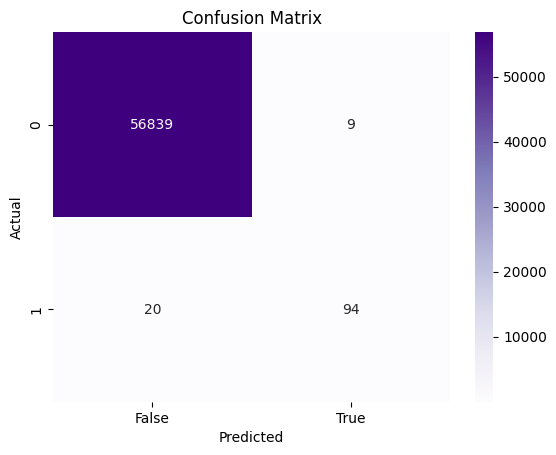

In [15]:
import seaborn as sns
confusion_matrix = pd.crosstab(y_test.values.T, y_pred.values.T, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Purples', fmt='g')
plt.title('Confusion Matrix')
plt.savefig('ressources/plots/confusion_matrix_ml.png')